In [1]:
import matplotlib.pyplot as plt
from torch import optim
import lightning.pytorch as pl 
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch
import torch.nn.functional as F
import torchmetrics
from helpers import MNISTDataModule
from models.opt import Autoencoder
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.decomposition import PCA

sns.set()


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [2]:
class Model(pl.LightningModule):
    def __init__(self, projection_layer,n_constraint):
        super().__init__()
        self.model = Autoencoder(projection_layer=projection_layer,n_constraint=n_constraint)
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x,x_true, y = batch
        x_hat,y_pred, x_proj,x_latent = self.forward(x)
        loss = F.mse_loss(x_hat, x_true)
        loss_b=F.cross_entropy(y_pred,y)
        self.accuracy(y_pred, y)
        self.log('train_acc_step', self.accuracy)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss+loss_b
    
    def on_train_epoch_end(self):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy)
    
    def forward(self,x):
        out=self.model(x)
        return out
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x,x_true, y = batch
        x_hat,y_pred,x_proj,x_latent = self.forward(x)
        val_loss = F.mse_loss(x_hat, x_true)
        self.valid_acc(y_pred, y)
        self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x,x_true, y = batch
        x_hat,y_pred,x_proj,x_latent = self.forward(x)
        test_loss = F.mse_loss(x_hat, x_true)
        self.test_acc(y_pred, y)
        self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
pl.seed_everything(42, workers=True)
model=Model(True,n_constraint=64)
tb_logger = pl_loggers.TensorBoardLogger(save_dir="./")
trainer = pl.Trainer(max_epochs=100,logger=tb_logger,callbacks=[EarlyStopping(monitor='val_loss')],deterministic=True)
data_module=MNISTDataModule(noise_level_train=0.0)
trainer.fit(model, datamodule=data_module)

In [7]:
trainer.test(ckpt_path="best",datamodule=data_module)

Restoring states from the checkpoint path at ./lightning_logs/version_30/checkpoints/epoch=22-step=1955.ckpt
Loaded model weights from the checkpoint at ./lightning_logs/version_30/checkpoints/epoch=22-step=1955.ckpt
/opt/miniconda3/envs/implicit_layers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 16/16 [00:35<00:00,  2.25s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9610000252723694     │
│         test_loss         │    0.6066446900367737     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc_epoch': 0.9610000252723694, 'test_loss': 0.6066446900367737}]

In [5]:
pl.seed_everything(42, workers=True)
tb_logger = pl_loggers.TensorBoardLogger(save_dir="./")
trainer = pl.Trainer(max_epochs=100,logger=tb_logger,callbacks=[EarlyStopping(monitor='val_loss')],deterministic=True)
data_module=MNISTDataModule()

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
# load model
#model = Model.load_from_checkpoint("./lightning_logs/version_30/checkpoints/epoch=22-step=1955.ckpt")
model.eval()
errors=[]
# noise level
noise_level=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for noise in noise_level:
    data_module=MNISTDataModule(noise_level_test=noise)
    error=trainer.test(model,datamodule=data_module)[0]
    errors.append(error)
errors=pd.DataFrame(errors,index=noise_level)

/opt/miniconda3/envs/implicit_layers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9800000190734863     │
│         test_loss         │    0.5473454594612122     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8744999766349792     │
│         test_loss         │    0.6137423515319824     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8769999742507935     │
│         test_loss         │    0.6129041314125061     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │           0.875           │
│         test_loss         │    0.6122521758079529     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8684999942779541     │
│         test_loss         │    0.6125696301460266     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8700000047683716     │
│         test_loss         │    0.6117801666259766     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8500000238418579     │
│         test_loss         │    0.6122536063194275     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8464999794960022     │
│         test_loss         │    0.6123627424240112     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8410000205039978     │
│         test_loss         │     0.614274263381958     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8054999709129333     │
│         test_loss         │    0.6167175769805908     │
└───────────────────────────┴───────────────────────────┘

In [131]:
model = Model.load_from_checkpoint("./lightning_logs/version_37/checkpoints/epoch=44-step=3825.ckpt")

In [12]:
model = Model.load_from_checkpoint("./lightning_logs/version_34/checkpoints/epoch=55-step=4760.ckpt")
model.eval()
errors2=[]
# noise level
noise_level=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for noise in noise_level:
    data_module=MNISTDataModule(noise_level_test=noise)
    error=trainer.test(model,datamodule=data_module)[0]
    errors2.append(error)


/opt/miniconda3/envs/implicit_layers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9804999828338623     │
│         test_loss         │    0.5310635566711426     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 36.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.7055000066757202     │
│         test_loss         │    0.6543287634849548     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 37.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.7014999985694885     │
│         test_loss         │    0.6528300046920776     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6934999823570251     │
│         test_loss         │    0.6519984006881714     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 37.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6884999871253967     │
│         test_loss         │    0.6510143280029297     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6894999742507935     │
│         test_loss         │    0.6500486731529236     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 26.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6769999861717224     │
│         test_loss         │    0.6504947543144226     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6754999756813049     │
│         test_loss         │    0.6488659381866455     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 19.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6639999747276306     │
│         test_loss         │    0.6494614481925964     │
└───────────────────────────┴───────────────────────────┘

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 34.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6740000247955322     │
│         test_loss         │    0.6486355662345886     │
└───────────────────────────┴───────────────────────────┘

In [13]:
errors2=pd.DataFrame(errors2,index=noise_level)

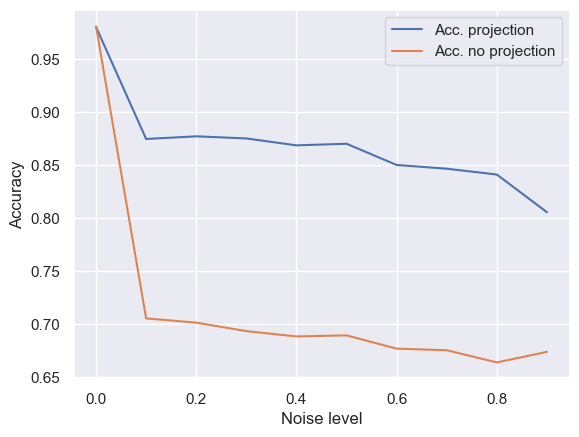

In [23]:
ax=errors["test_acc_epoch"].plot(label="Acc. projection")
errors2["test_acc_epoch"].plot(ax=ax,label="Acc. no projection")
plt.xlabel("Noise level")
plt.ylabel("Accuracy")
plt.legend()

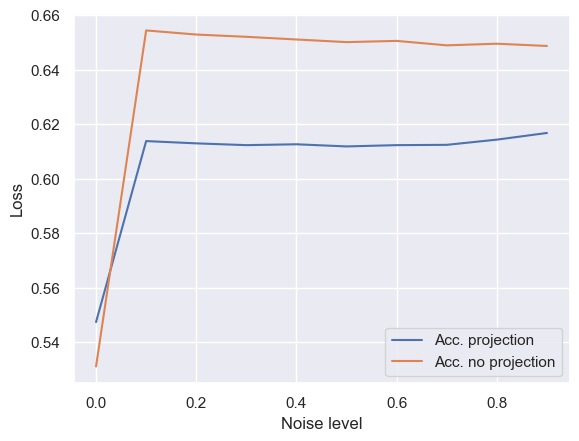

In [24]:
ax=errors["test_loss"].plot(label="Acc. projection")
errors2["test_loss"].plot(ax=ax,label="Acc. no projection")
plt.xlabel("Noise level")
plt.ylabel("Loss")
plt.legend()

In [132]:
noise=0.5
data_module=MNISTDataModule(noise_level_test=noise)
data_module.prepare_data()
data_module.setup("test")
dataloader=data_module.test_dataloader()
latent=[]
latent_proj=[]
labels=[]
noisy=[]
for batch in tqdm(dataloader):
    img_noisy,img,label=batch
    out=model.forward(img_noisy)
    latent.append(out[2].detach())
    latent_proj.append(out[3].detach())
    labels.append(label.detach())
latent=torch.cat(latent,dim=0)
latent_proj=torch.cat(latent_proj,dim=0)
labels=torch.cat(labels,dim=0)

100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


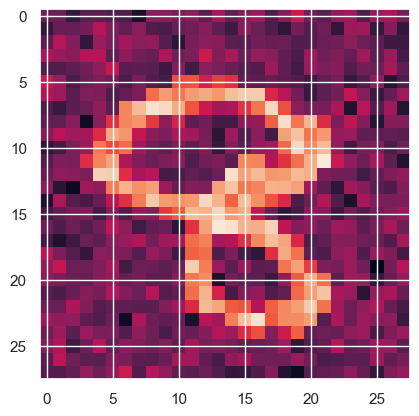

In [133]:
plt.imshow(img_noisy[2,0].detach().numpy())

In [138]:
n=latent.shape[0]
X=torch.cat([latent.squeeze(),latent_proj],dim=0).squeeze().numpy()
X_vis=TSNE().fit_transform(X)
X_vis_lat=X_vis[:n]
X_vis_proj=X_vis[n:]

/opt/miniconda3/envs/implicit_layers/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:362: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


In [147]:

X=latent_proj.squeeze().numpy()
m=PCA(n_components=2)
X_vis=m.fit_transform(X)
X_vis_lat2=m.fit_transform(latent.squeeze().numpy())
X_vis_proj2=X_vis

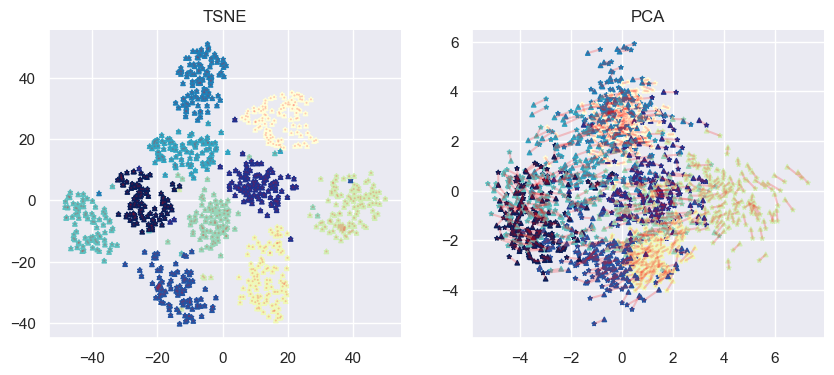

In [153]:
import seaborn as sns
sns.set()
fig,axs=plt.subplots(1,2,figsize=(10,4))
ax=axs[0]
ax.scatter(X_vis_proj[:1000,0],X_vis_proj[:1000,1],c=labels[:1000].view(-1).numpy(),s=10,marker="*",cmap="YlGnBu",label="Projection")
ax.scatter(X_vis_lat[:1000,0],X_vis_lat[:1000,1],c=labels[:1000].view(-1).numpy(),s=10,marker="^",cmap="YlGnBu",label="Latent")
for i in range(1000):
    ax.plot([X_vis_lat[i,0],X_vis_proj[i,0]],[X_vis_lat[i,1],X_vis_proj[i,1]],color="red",alpha=0.2)
ax.set_title("TSNE") 
ax=axs[1]
ax.scatter(X_vis_proj2[:1000,0],X_vis_proj2[:1000,1],c=labels[:1000].view(-1).numpy(),s=10,marker="*",cmap="YlGnBu",label="Projection")
ax.scatter(X_vis_lat2[:1000,0],X_vis_lat2[:1000,1],c=labels[:1000].view(-1).numpy(),s=10,marker="^",cmap="YlGnBu",label="Latent")
for i in range(1000):
    ax.plot([X_vis_lat2[i,0],X_vis_proj2[i,0]],[X_vis_lat2[i,1],X_vis_proj2[i,1]],color="red",alpha=0.2)
ax.set_title("PCA")
sns.despine(fig)


In [45]:
from torchsummary import summary

summary(model.model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 14, 14]              60
       BatchNorm2d-2            [-1, 6, 14, 14]              12
              ReLU-3            [-1, 6, 14, 14]               0
            Conv2d-4             [-1, 16, 7, 7]             880
       BatchNorm2d-5             [-1, 16, 7, 7]              32
              ReLU-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 4, 4]           4,640
       BatchNorm2d-8             [-1, 32, 4, 4]              64
              ReLU-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 1, 1]          32,832
             ReLU-11             [-1, 64, 1, 1]               0
           Linear-12                   [-1, 20]           1,300
             ReLU-13                   [-1, 20]               0
           Linear-14                   